# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [1]:
import json

with open('train-claims.json', 'r') as f:
  train_claims_data = json.load(f)

with open('dev-claims.json', 'r') as f:
  train_labels_data = json.load(f)

with open('test-claims-unlabelled.json', 'r') as f:
  dev_claims_data = json.load(f)

with open('evidence.json', 'r') as f:
  evidence_data = json.load(f)

In [ ]:
import json
import pandas as pd
import numpy as np
from collections import Counter

# Prepare statistics
claim_lengths = []
evidence_lengths = []
evidence_counts = []
labels = []

label_counter = Counter()

for claim_id, claim_data in train_claims_data.items():
    claim = claim_data["claim_text"]
    label = claim_data["claim_label"]
    evid_ids = claim_data.get("evidences", [])

    claim_lengths.append(len(claim.split()))
    evidence_counts.append(len(evid_ids))
    labels.append(label)
    label_counter[label] += 1

    for evid_id in evid_ids:
        if evid_id in evidence_data:
            ev_text = evidence_data[evid_id]
            evidence_lengths.append(len(ev_text.split()))

# Print summary statistics
print(f"Total claims: {len(train_claims_data)}")
print(f"Label distribution: {label_counter}")
print(f"Claim length - max: {max(claim_lengths)}, min: {min(claim_lengths)}, mean: {np.mean(claim_lengths):.2f}")
print(f"Evidence count per claim - max: {max(evidence_counts)}, min: {min(evidence_counts)}, mean: {np.mean(evidence_counts):.2f}")
print(f"Evidence text length - max: {max(evidence_lengths)}, min: {min(evidence_lengths)}, mean: {np.mean(evidence_lengths):.2f}")

Total claims: 1228
Label distribution: Counter({'SUPPORTS': 519, 'NOT_ENOUGH_INFO': 386, 'REFUTES': 199, 'DISPUTED': 124})
Claim length - max: 67, min: 4, mean: 20.10
Evidence count per claim - max: 5, min: 1, mean: 3.36
Evidence text length - max: 276, min: 3, mean: 27.63


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
Vector Embedding Using BERT

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

# Load embedding model and move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedder = SentenceTransformer('facebook/bart-large-mnli').to(device)

# Assume you have `train_claims_data` and `evidence_data` already loaded
claim_texts = [claim["claim_text"] for claim in train_claims_data.values()]
claim_ids = list(train_claims_data.keys())

evid_ids = list(evidence_data.keys())
evid_texts = [evidence_data[eid] for eid in evid_ids]

evid_texts = evid_texts[:50000]
evid_ids = evid_ids[:50000]

In [ ]:
claim_vecs = embedder.encode(
    claim_texts,
    batch_size=64,
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

evid_vecs = embedder.encode(
    evid_texts,
    batch_size=64,
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

In [ ]:
Pre-Ranking via Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

top_k_matches = {}
k = 5

for i, claim_vec in enumerate(claim_vecs):
  scores = cosine_similarity(claim_vec.cpu().numpy().reshape(1, -1), evid_vecs.cpu().numpy())[0]
  top_k_idx = np.argsort(scores)[-k:][::-1]
  top_k_evids = [evid_ids[j] for j in top_k_idx]
  top_k_matches[claim_ids[i]] = top_k_evids


In [12]:
# Construct training data for re-ranking model
from datasets import Dataset

label_map = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}

pair_data = []
for cid in claim_ids:
  claim_obj = train_claims_data[cid]
  claim_text = claim_obj["claim_text"]
  claim_label_str = claim_obj["claim_label"]
  label = label_map[claim_label_str]
  candidate_evids = top_k_matches[cid]

  for evid in candidate_evids:
    if evid in evidence_data:
      evidence_text = evidence_data[evid]
      pair_data.append({
          "text": claim_text + " [SEP] " + evidence_text, "label": label
      })


In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import torch.nn as nn

class WeightedLossTrainer(Trainer):
  def __init__(self, class_weights, *args, **kwargs):
    super().__init__(*args, **kwargs)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss = self.loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss


In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = Dataset.from_list(pair_data)

def preprocess(example):
    return tokenizer(example['text'], truncation=True, padding='max_length')

encoded_dataset = dataset.map(preprocess, batched=True)

# Train/test split
split_data = encoded_dataset.train_test_split(test_size=0.2)
train_dataset = split_data["train"]
eval_dataset = split_data["test"]

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

args = TrainingArguments(
    output_dir="./bert-reranker",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

trainer.train()


In [31]:
from sklearn.utils.class_weight import compute_class_weight

y_train = [item["label"] for item in pair_data]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [21]:
trainer.save_model("bert-classifier")

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [15]:
from sklearn.metrics import classification_report

# Get model predictions
outputs = trainer.predict(eval_dataset)
y_pred = np.argmax(outputs.predictions, axis=1)
y_true = outputs.label_ids

label_map = {0: "SUPPORTS", 1: "REFUTES", 2: "NOT_ENOUGH_INFO", 3: "DISPUTED"}
target_names = [label_map[i] for i in sorted(label_map)]

print(classification_report(y_true, y_pred, target_names=target_names, digits=3))


                 precision    recall  f1-score   support

       SUPPORTS      0.964     0.984     0.974       516
        REFUTES      0.966     0.966     0.966       203
NOT_ENOUGH_INFO      0.967     0.972     0.970       362
       DISPUTED      0.955     0.871     0.911       147

       accuracy                          0.964      1228
      macro avg      0.963     0.948     0.955      1228
   weighted avg      0.964     0.964     0.964      1228



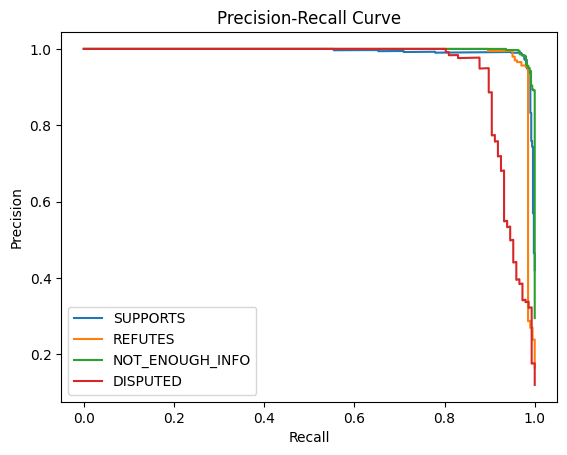

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Binarize the output
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
y_score = outputs.predictions

# Plot precision-recall curve for each class
for i in range(len(label_map)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=label_map[i])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [17]:
from datasets import Dataset

label_map = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}

eval_pair_data = []
for cid, claim_obj in train_labels_data.items():
  claim_text = claim_obj["claim_text"]
  label_str = claim_obj["claim_label"]
  label = label_map[label_str]
  for evid_id in claim_obj["evidences"]:
    if evid_id in evidence_data:
      evidence_text = evidence_data[evid_id]
      eval_pair_data.append({"text": claim_text + " [SEP] " + evidence_text, "label": label})

eval_dataset = Dataset.from_list(eval_pair_data)

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def preprocess(example):
  return tokenizer(example['text'], truncation=True, padding='max_length')

encoded_eval_dataset = eval_dataset.map(preprocess, batched=True)

In [ ]:
trainer = Trainer(model=model, tokenizer=tokenizer)

outputs = trainer.predict(encoded_eval_dataset)

In [20]:
y_pred = np.argmax(outputs.predictions, axis=1)
y_true = outputs.label_ids

inv_label_map = {v: k for k, v in label_map.items()}
target_names = [inv_label_map[i] for i in sorted(inv_label_map)]

print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

                 precision    recall  f1-score   support

       SUPPORTS      0.444     0.743     0.556       171
        REFUTES      0.344     0.193     0.247        57
NOT_ENOUGH_INFO      0.520     0.376     0.436       205
       DISPUTED      0.360     0.155     0.217        58

       accuracy                          0.456       491
      macro avg      0.417     0.367     0.364       491
   weighted avg      0.454     0.456     0.430       491



In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("/content/bert-classifier")
model.eval()

In [23]:
label_map = {0: "SUPPORTS", 1: "REFUTES", 2: "NOT_ENOUGH_INFO", 3: "DISPUTED"}
predictions = {}

for claim_id, claim_info in train_labels_data.items():
    claim_text = claim_info["claim_text"]
    evidence_ids = claim_info["evidences"]

    # Combine claim with each evidence
    inputs = []
    for evid_id in evidence_ids:
        evidence_text = evidence_data.get(evid_id, "")
        combined_text = claim_text + " [SEP] " + evidence_text
        inputs.append(combined_text)

    # Tokenize inputs
    encodings = tokenizer(inputs, truncation=True, padding=True, return_tensors="pt")

    # Get model predictions
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=1)

    # Majority vote if multiple evidences
    predicted_class = torch.mode(predicted_classes).values.item()
    predicted_label = label_map[predicted_class]

    predictions[claim_id] = {
        "claim_label": predicted_label,
        "evidences": evidence_ids  # or select top-k based on your criteria
    }

# Save predictions to a JSON file
with open("predictions.json", "w") as f:
    json.dump(predictions, f, indent=2)


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
encodings = {key: val.to(device) for key, val in encodings.items()}
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
# Test via eval.py
!python eval.py --predictions predictions.json --groundtruth dev-claims.json

Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.4675324675324675
Harmonic Mean of F and A          = 0.6371681415929203


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*